# Import

In [37]:
import sys
sys.path.append('/home/aistudio/external-libraries')

import jax
import jax.numpy as jnp
import jax.random as random
import optax
import jaxopt
import numpy as np

jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.ticker as ticker
from scipy.stats import qmc
import time
import pandas as pd
import process_log
import os
import shutil
from ddeint import ddeint


font_path = '/home/aistudio/external-libraries/Times_New_Roman.ttf'
path = '/home/aistudio/PINN-PDDEs/PD-ODE'
prop = font_manager.FontProperties(fname=font_path)

picture_path = os.path.join(path, 'ODE_IP_ex2_picture_result')
os.makedirs(picture_path, exist_ok=True)
result_path = os.path.join(path, 'ODE_IP_ex2_result')
os.makedirs(result_path, exist_ok=True)

log_path = os.path.join(result_path, 'log')
os.makedirs(log_path, exist_ok=True)

# Configuration

In [38]:
# config = {
#     "q": 0.5,
#     "tmin": 0.,
#     "tmax": 1.,
#     "initial_key": 0,
#     "netLayers": [1, 20, 40, 20, 1],
#     "activation_function": 1,
#     "N_f": 5000,
#     "N_g": 5,
#     "noise": 0.1,
#     "lambda_reg" : 1e-5,  # Regularization coefficient
#     "step_epochs": [5001, 10001],
# #    "step_epochs": [21, 41],
#     "log_path": os.path.join(log_path,f"log.txt"),
#     "picture_path": picture_path
# }
# results = []

# Definition of the equation and its exact solution
The considered equation is as follows:
$$
\begin{cases}
\dfrac{dy(t)}{dt} = -y(t) + e^{(q-1)t} \cdot y(qt) + e^{-t} \cdot \left(\frac{\pi}{2q}\cos\left(\frac{\pi t}{2q}\right) - \sin\left(\frac{\pi t}{2}\right)\right), & \quad t \geq 0 \\
y(0) = 0,  & \quad t = 0
\end{cases}.
$$
The analytical solution of this equation is:
$$
 y(t)=e^{-t} \cdot \sin \left(\frac{\pi t}{2 q}\right)
$$

In [39]:
for key, value in config.items():
    globals()[key] = value

def PDDE(t, u, q_pred):
    u_t = lambda t: jax.grad(lambda t: jnp.sum(u(t)))(t)
    rhs = -u(t) + jnp.exp((q-1)*t)*u(q_pred*t) + jnp.exp(-t)* ((jnp.pi/2/q)*jnp.cos(jnp.pi*t/2/q)-jnp.sin(jnp.pi*t/2))
    return u_t(t) - rhs

def u_bound1(t_min):
    return 0 

# exact solution
def u(t):
    return jnp.exp(-t)*jnp.sin(jnp.pi*t/2/q)

# Definition of the loss functions

In [40]:
def loss_fun1(params, inPoints, obs_data):
    t_c = inPoints[:,[0]]
    t_g, u_g = obs_data[:, [0]], obs_data[:, [1]]

    q_pred = jnp.exp(params[-1][0])
    ufunc = lambda t: DNNs(params[:-1], t)
    ufunc_t = lambda t: jax.grad(lambda t: jnp.sum(ufunc(t)))(t)

    loss_f = jnp.mean(PDDE(t_c, ufunc, q_pred)**2)
    loss_i = jnp.mean((ufunc(tmin) - u_bound1(tmin))**2)
    loss_g = jnp.mean((u_g - ufunc(t_g))**2)

    # Calculate the L2 regularization term
    l2_reg = 0.0
    for param in params[:-1]:
        w, b = param
        l2_reg += jnp.sum(jnp.square(w))
    l2_reg *= lambda_reg 

    all_losses = jnp.array([loss_f, loss_i, loss_g, l2_reg])
    total_loss = jnp.sum(all_losses)
    weights = all_losses / total_loss
    loss_weighted = jnp.sum(all_losses * weights)
    return loss_weighted, all_losses

def loss_fun2(params, inPoints, obs_data, initial_weights):
    t_c = inPoints[:,[0]]
    t_g, u_g = obs_data[:, [0]], obs_data[:, [1]]

    q_pred = jnp.exp(params[-1][0])
    ufunc = lambda t: DNNs(params[:-1], t)
    ufunc_t = lambda t: jax.grad(lambda t: jnp.sum(ufunc(t)))(t)

    loss_f = jnp.mean(PDDE(t_c, ufunc, q_pred)**2)
    loss_i = jnp.mean((ufunc(tmin) - u_bound1(tmin))**2)
    loss_g = jnp.mean((u_g - ufunc(t_g))**2)

    l2_reg = 0.0
    for param in params[:-1]:
        w, b = param
        l2_reg += jnp.sum(jnp.square(w))
    l2_reg *= lambda_reg 

    all_losses = jnp.array([loss_f, loss_i, loss_g, l2_reg])
    loss_weighted = jnp.sum(all_losses * initial_weights)
    return loss_weighted, all_losses

# DNNs Model Definition and Parameter Initialization

In [41]:
def DNNs(params, t):
    def activate(t):
        if activation_function == 1:
            return jnp.tanh(t)
        elif activation_function == 2:
            return jnp.maximum(0, t)  # ReLU
        elif activation_function == 3:
            return 1 / (1 + jnp.exp(-t))  # Sigmoid
        elif activation_function == 4:
            return jnp.sin(t)

    for w, b in params[:-1]:
        t = jnp.dot(t, w) + b
        t = activate(t)

    w, b = params[-1]
    t = jnp.dot(t, w) + b
    return t


# Xavier initialization for the layer parameters
def random_layer_params_xavier(m, n, key):
    # Compute standard deviation for Xavier initialization
    xavier_stddev = jnp.sqrt(2.0 / (m + n))
    # Split random key for weights and biases
    w_key, b_key = jax.random.split(key)
    # Generate truncated normal weights (±2 standard deviations)
    weights = xavier_stddev * jax.random.truncated_normal(
        w_key, lower=-2.0, upper=2.0, shape=(m, n)
    )
    # Initialize biases to zero
    biases = jnp.zeros((n,))
    return weights, biases

# Initialize parameters for all layers in a fully-connected neural network with the specified sizes
def init_network_params(sizes, key):
    keys = jax.random.split(key, len(sizes))
    return [random_layer_params_xavier(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

# Definition of the optimizers

In [42]:
def train_adam(
    params,
    loss_fn,
    loss_args: dict,
    solver_config: dict = None
):
    # Default optimizer configuration
    solver_config_defaults = {
        "init_value": 1e-3,
        "decay_steps": 1000,
        "alpha": 0.01,
        "num_epochs": 2000,
        "start_epoch": 0,
        "record_info": False,
        "log_interval": 10,
        "print_interval": 100
    }

    # Merge provided settings with defaults
    cfg = {**solver_config_defaults, **(solver_config or {})}

    # Initialize containers for logging
    phase_epochs, phase_losses, phase_loss_terms, phase_q = [], [], [], []

    # Set up learning rate scheduler and optimizer
    scheduler = optax.cosine_decay_schedule(
        init_value=cfg['init_value'],
        decay_steps=cfg['decay_steps'],
        alpha=cfg['alpha']
    )
    optimizer = optax.adam(learning_rate=scheduler)
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        (loss, all_losses), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, **loss_args)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss, all_losses

    # Main training loop
    for epoch in range(cfg['num_epochs']):
        params, opt_state, loss, all_losses = update(params, opt_state)
        current_epoch = cfg['start_epoch'] + epoch

        # Log information
        if cfg['record_info'] and current_epoch % cfg['log_interval'] == 0:
            phase_epochs.append(current_epoch)
            phase_losses.append(loss)
            phase_loss_terms.append(all_losses)
            phase_q.append(params[-1])

        # Print training progress
        if cfg['record_info'] and current_epoch % cfg['print_interval'] == 0:
            print(f"Epoch {current_epoch}, Total Loss: {loss:.3e}")

    return (
        params,
        phase_epochs if cfg['record_info'] else None,
        phase_losses if cfg['record_info'] else None,
        phase_loss_terms if cfg['record_info'] else None,
        phase_q if cfg['record_info'] else None,
        all_losses
    )

def train_lbfgs(
    params,
    loss_fn,
    loss_args: dict,
    solver_config: dict = None,
):
    if solver_config is None:
        solver_config = {}

    # Default optimizer configuration
    solver_config_defaults = {
        "tol": 1e-18,
        "maxiter": 10000,
        "verbose": False,
        "log_to_file": False,
        "logfile": "log.txt",
        "log_target_param": False
    }

    # Merge provided settings with defaults
    cfg = {**solver_config_defaults, **solver_config}

    # Wrap the objective function to match the BFGS signature
    def wrapped_loss_fn(p):
        return loss_fn(p, **loss_args)

    # Construct the custom BFGS solver
    solver = jaxopt.My_BFGS(
        fun=wrapped_loss_fn,
        has_aux=True,
        **cfg
    )

    sol = solver.run(params)
    return sol.params, sol.state.aux

# Initialization

In [43]:
# Generate random points
sampler = qmc.LatinHypercube(d=1)
sample = sampler.random(n=N_f)
scaled_sample = qmc.scale(sample, tmin, tmax)
inPoints = jnp.array(scaled_sample)

# Generate observation points
jaxKey = jax.random.PRNGKey(initial_key)
jaxKey, t_key, noise_key = jax.random.split(jaxKey, 3)
t_g = jax.random.uniform(t_key, shape=(N_g, 1), minval=tmin, maxval=tmax, dtype='float64')
u_g = u(t_g)
noise_level = noise * jax.random.truncated_normal(noise_key, -3, 3, u_g.shape)
u_g_noise = u_g * (1 + noise_level)
obs_data = jnp.column_stack((t_g, u_g_noise))

# Initialize network parameters
params = init_network_params(netLayers, jaxKey)
q_params = jnp.array([jnp.log(0.1)], dtype=jnp.float64)
params.append(q_params)

# Training

In [44]:
start_time_nn = time.time()

# Step 1: Adam optimizer
solver_config_adam = {
    "init_value": 1e-2,
    "decay_steps": 1000,
    "alpha": 0.01,
    "num_epochs": config["step_epochs"][0],
    "start_epoch": 0,
    "record_info": True,
    "log_interval": 10,
    "print_interval": 1000
}
loss_args_adam = {
    "inPoints": inPoints,
    "obs_data": obs_data
}
params, hist1_epoch, hist1_loss, hist1_loss_terms, hist1_lag, loss_components= train_adam(
    params,
    loss_fun1,
    loss_args_adam,
    solver_config_adam
)
losses = jax.lax.stop_gradient(loss_components)
initial_weights = losses / jnp.sum(losses)

# Step 2: LBFGS optimizer
solver_config_lbfgs = {
    "tol": 1e-16,
    "maxiter": config["step_epochs"][1],
    "verbose": False,
    "log_to_file": True,
    "logfile": log_path,
    "log_target_param": True
}
loss_args_lbfgs = {
    "inPoints": inPoints,
    "obs_data": obs_data,
    "initial_weights": initial_weights
}

params, _ = train_lbfgs(params, loss_fun2, loss_args_lbfgs, solver_config_lbfgs)

end_time_nn = time.time()
time_nn = end_time_nn - start_time_nn

Epoch 0, Total Loss: 2.380e+00
Epoch 1000, Total Loss: 5.046e-04
Epoch 2000, Total Loss: 4.771e-04
Epoch 3000, Total Loss: 4.471e-04
Epoch 4000, Total Loss: 4.232e-04
Epoch 5000, Total Loss: 4.076e-04


# Calculation of the solution effect of DNNs

In [45]:
# DNNs
T = np.linspace(tmin, tmax, 5000).reshape(-1, 1)
nn_sol = DNNs(params[:-1], T)
rr_sol = u(T)

nn_error = nn_sol - rr_sol
abs_error_nn_rr = np.abs(nn_error)
rel_error_nn_rr = np.linalg.norm(nn_error, ord=2) / np.linalg.norm(rr_sol, ord=2)
mae_nn_rr = np.mean(abs_error_nn_rr)

q_pred = jnp.exp(params[-1][0]).item()
absolute_error_q = abs(q_pred - q)
relative_error_q = absolute_error_q / q

# record the result
result = {    
    "q_TV": q,
    "q_PV": "{:.6f}".format(q_pred),
    "noise": noise,
    "RE": "{:.6e}".format(rel_error_nn_rr),
    "AE": "{:.6e}".format(mae_nn_rr),
    "q_RE": "{:.6e}".format(relative_error_q),
    "q_AE": "{:.6e}".format(absolute_error_q),
    "time_nn": time_nn
}
print(result)
results.append(result)

{'q_TV': 0.5, 'q_PV': '0.465813', 'noise': 0.1, 'RE': '9.126558e-03', 'AE': '3.525771e-03', 'q_RE': '6.837452e-02', 'q_AE': '3.418726e-02', 'time_nn': 75.82877230644226}


# Visualization of numerical solutions

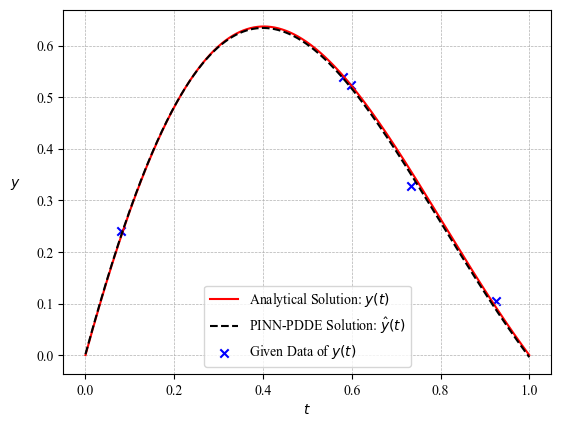

In [46]:
#Uniform image size
figsize = (16 / 2.54, 12 / 2.54)

# 2D Contour Plot
fig = plt.figure(figsize=figsize)
plt.plot(T, rr_sol, '-r', label='Analytical Solution: $y(t)$')
plt.plot(T, nn_sol, '--k', label='PINN-PDDE Solution: $\hat{y}(t)$')
plt.scatter(t_g, u_g_noise, label='Given Data of $y(t)$', color='blue', marker='x')
plt.xlabel('$t$', fontproperties=prop)
plt.ylabel('$y$', rotation=0, labelpad=15, fontproperties=prop)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(prop)
plt.legend(prop=prop, loc='best')                
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)
plot_path = os.path.join(picture_path, 'nn_solution.png')
plt.savefig(plot_path, dpi=600, bbox_inches='tight')
plt.show()
plt.close(fig)

# Visualization of numerical solution errors

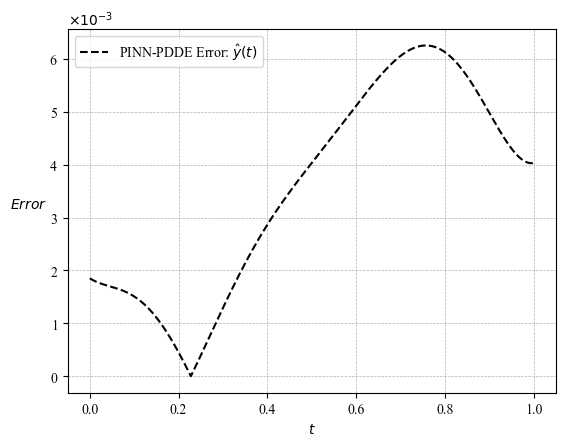

In [47]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))

fig = plt.figure(figsize=figsize)
plt.plot(T, abs_error_nn_rr, '--k', label='PINN-PDDE Error: $\hat{y}(t)$')
plt.xlabel('$t$', fontproperties=prop)
plt.ylabel('$Error$', rotation=0, labelpad=15, fontproperties=prop)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(prop)
plt.legend(prop=prop, loc='best')         
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)
plot_path = os.path.join(picture_path, 'error_2d.png')
plt.savefig(plot_path, dpi=600, bbox_inches='tight')
plt.show()
plt.close(fig)

# Visualization of loss value changes

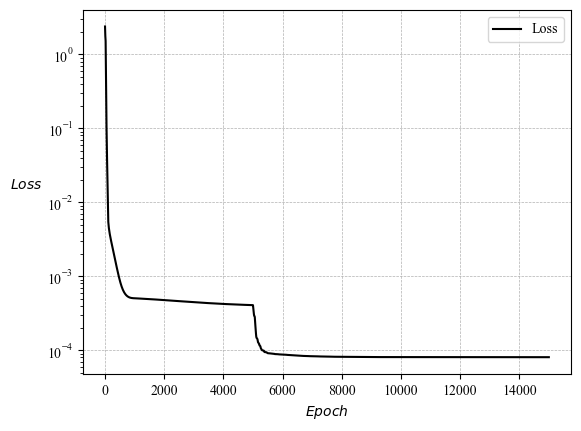

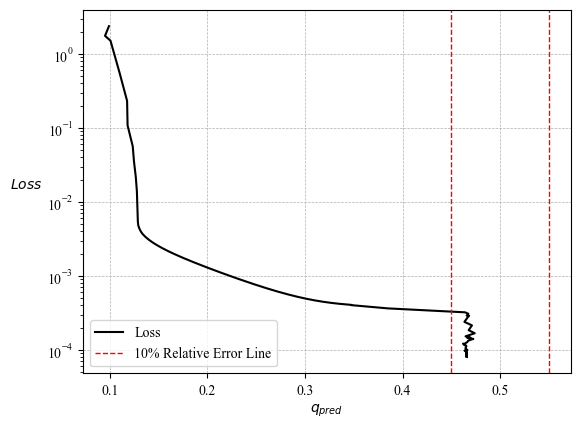

In [48]:
adam_arr, col_names = process_log.format_adam_log(hist1_epoch, hist1_loss, hist1_lag)
bfgs_arr, col_names = process_log.extract_bfgs_info(log_path, step_epochs[0], 10, extract_target_params = True)
all_arr = np.vstack([adam_arr, bfgs_arr])

epoch_history = all_arr[:, 0]
loss_history = all_arr[:, 1]
q_history = all_arr[:, 2]

q_history = jnp.exp(q_history)

if noise != 0:
    error_percentage = int(noise * 100)
else:
    error_percentage = 1
q_lower_bound, q_upper_bound= (
    q * (1 - error_percentage / 100), 
    q * (1 + error_percentage / 100))

# Loss
fig = plt.figure(figsize=figsize)
plt.plot(epoch_history, loss_history, 'k', label='Loss')
plt.yscale('log')
plt.xlabel('$Epoch$', fontproperties=prop)
plt.ylabel('$Loss$', rotation=0, labelpad=15, fontproperties=prop)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(prop)
plt.legend(prop=prop, loc='best')                
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)
plot_path = os.path.join(picture_path, 'loss_history.png')
plt.savefig(plot_path, dpi=600, bbox_inches='tight')
plt.show()
plt.close(fig)


# q
fig = plt.figure(figsize=figsize)
plt.plot(q_history, loss_history, 'k', label='Loss')
plt.yscale('log')
plt.xlabel('$q_{pred}$', fontproperties=prop)
plt.ylabel('$Loss$', rotation=0, labelpad=15, fontproperties=prop)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(prop)
plt.axvline(x=q_lower_bound, color='red', linestyle='--', linewidth=1, label=f'{error_percentage}% Relative Error Line')
plt.axvline(x=q_upper_bound, color='red', linestyle='--', linewidth=1)
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)
plt.legend(prop=prop, loc='best')
plot_path = os.path.join(picture_path, 'q_history.png')
plt.savefig(plot_path, dpi=600, bbox_inches='tight')
plt.show()
plt.close(fig)
